<a href="https://colab.research.google.com/github/Barissdal/Diabets_Prediction_Models/blob/main/Diabets_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install skompiler

     |████████████████████████████████| 45 kB 1.9 MB/s 
  Created wheel for skompiler: filename=SKompiler-0.6-py3-none-any.whl size=54286 sha256=03fc662efe9faf72efa901d9791718f72397550b825600a5fccd3a33dc1b5a17
  Stored in directory: /root/.cache/pip/wheels/47/1c/59/b80a730f4afd2144bad854df4b167b812486c9d4c1bd4cf4c5
Successfully built skompiler


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,ShuffleSplit,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,roc_curve, classification_report,mean_squared_error,f1_score,recall_score,precision_score
from sklearn.neighbors import KNeighborsClassifier,LocalOutlierFactor 
from sklearn.ensemble import RandomForestClassifier,BaseEnsemble,GradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
import time
from xgboost import XGBClassifier
from skompiler import skompile
from lightgbm import LGBMClassifier
from joblib import dump, load

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
df_ = pd.read_csv("/content/drive/MyDrive/resource/diabetes.csv")


In [7]:
df = df_.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Feature Engineering

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [16]:
df.Pregnancies.dtypes

dtype('int64')

In [24]:
def grab_col_names(dataframe, cat_th=3, car_th=10):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 14
cat_cols: 1
num_cols: 13
cat_but_car: 0
num_but_cat: 1


In [9]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [10]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [69]:
for col in num_cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [70]:
low, up = outlier_thresholds(df, "Insulin")
df[((df["Insulin"] < low) | (df["Insulin"] > up))].shape

(2, 9)

In [71]:
df[((df["Insulin"] < low) | (df["Insulin"] > up))]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
13,1,189,60,23,846,30.1,0.398,59,1
228,4,197,70,39,744,36.7,2.329,31,0


In [ ]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)

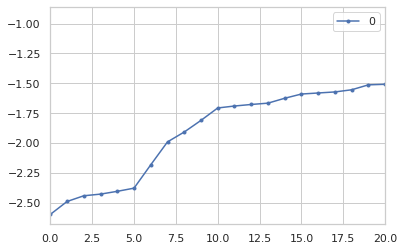

In [73]:
df_scores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()

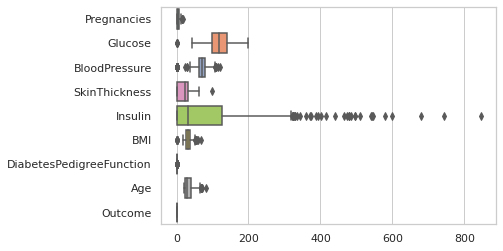

In [74]:
sns.set_theme(style="whitegrid")
sns.boxplot(data=df, orient="h", palette="Set2")
plt.show()

In [11]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [12]:
for i in df.columns:
 low, up = outlier_thresholds(df, i)
 if ((df[i] < low) | (df[i] > up)).any():
      print(f"\nIndices: {df[(df[i] < low) | (df[i] > up)].index}\n")
      print(df[(df[i] < low) | (df[i] > up)].head())
      replace_with_thresholds(df,i)



Indices: Int64Index([13, 228], dtype='int64')

     Pregnancies  Glucose  ...  Age  Outcome
13             1      189  ...   59        1
228            4      197  ...   31        0

[2 rows x 9 columns]


In [77]:
outlier_thresholds(df, "Insulin")

(-34.5, 113.5)

In [79]:
low, up = outlier_thresholds(df, "Insulin")

df[(df["Insulin"] < low) | (df["Insulin"] > up)].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


In [81]:
check_outlier(df, "Insulin")

False

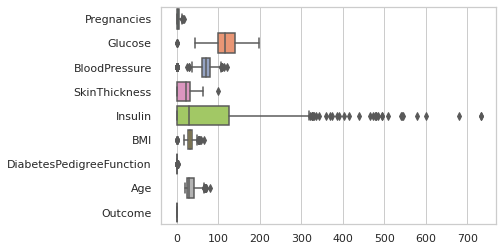

In [61]:
sns.set_theme(style="whitegrid")
sns.boxplot(data=df, orient="h", palette="Set2")
plt.show()

In [82]:
df.isnull().values.any()

False

In [83]:
for col in num_cols:
    print(col, outlier_thresholds(df, col))

Pregnancies (-15.0, 25.0)
Glucose (-74.0, 334.0)
BloodPressure (-38.249999999999986, 166.95)
SkinThickness (-66.0, 110.0)
Insulin (-439.5, 732.5)
BMI (-12.09249999999999, 78.2875)
DiabetesPedigreeFunction (-1.3483999999999996, 2.621599999999999)
Age (-34.5, 113.5)


In [13]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


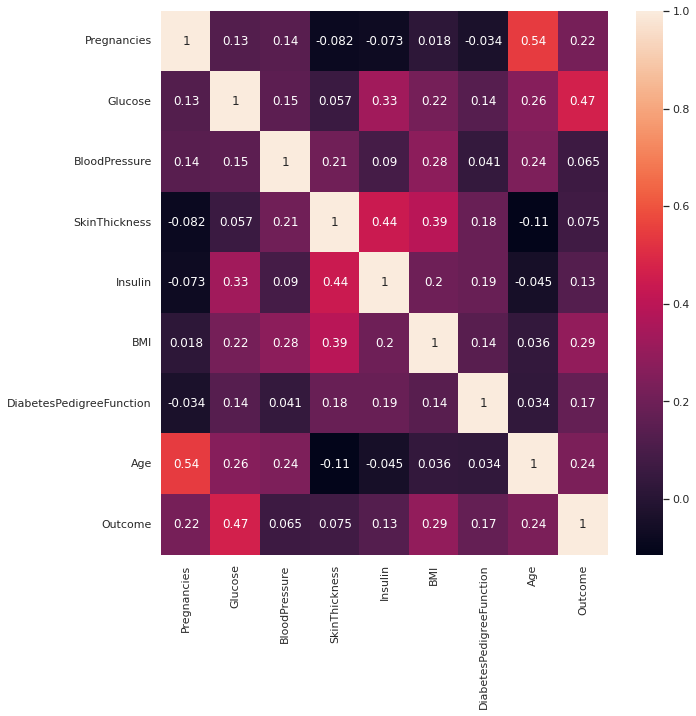

In [85]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


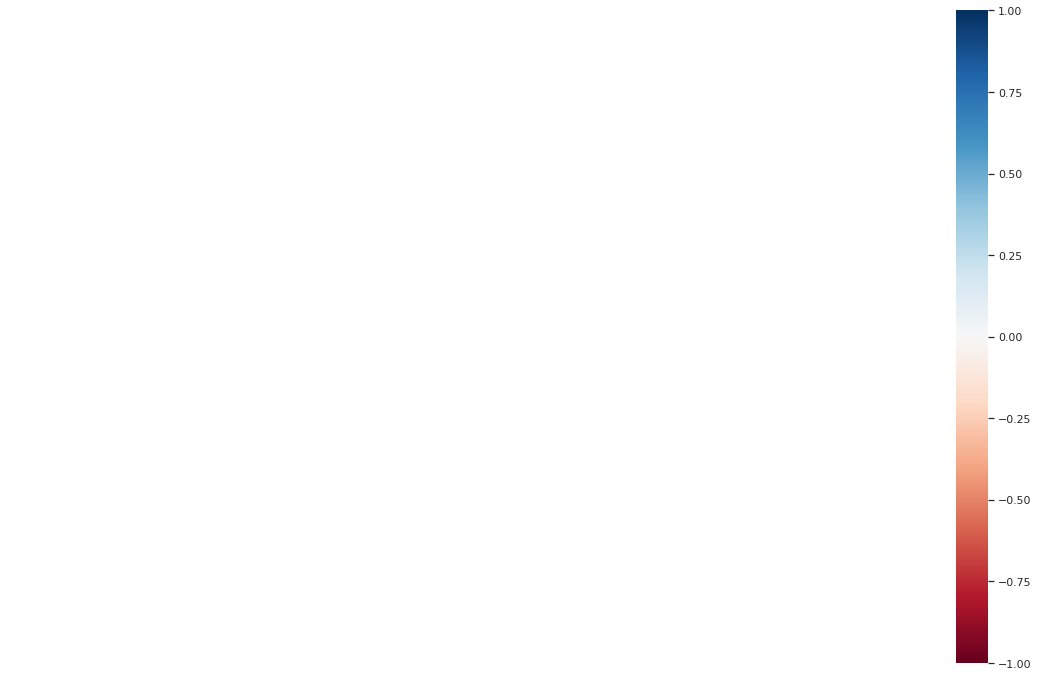

In [87]:
# heatmap
import missingno as msno
msno.heatmap(df)
plt.show()

In [14]:
# NaN assignment operations with values of 0
df["Glucose"].replace({0:np.nan},inplace=True)
df["BloodPressure"].replace({0:np.nan},inplace=True)
df["SkinThickness"].replace({0:np.nan},inplace=True)
df["Insulin"].replace({0:np.nan},inplace=True)
df["BMI"].replace({0:np.nan},inplace=True)
df["Age"].replace({0:np.nan},inplace=True)

In [89]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


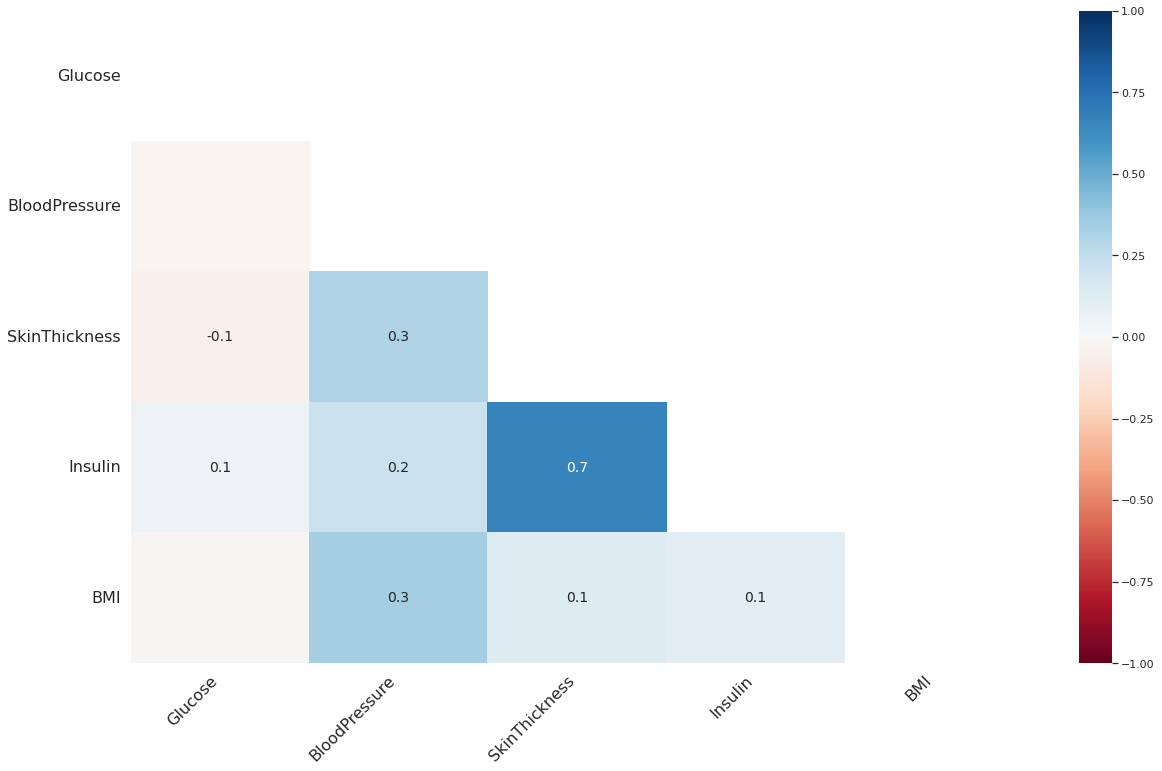

In [90]:
# heatmap
msno.heatmap(df)
plt.show()

In [91]:
# let's see missing values
missing_values_table(df)

               n_miss  ratio
Insulin           374  48.70
SkinThickness     227  29.56
BloodPressure      35   4.56
BMI                11   1.43
Glucose             5   0.65


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


In [15]:
cols = ["Glucose","Insulin","BloodPressure","SkinThickness","BMI"]

df = df.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [16]:
# let's see missing values
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


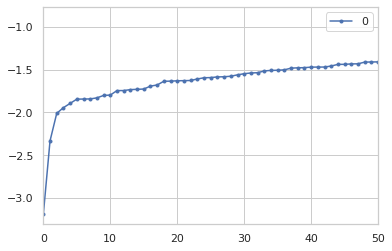

In [97]:
# finding and deleting outliers based on the principle of neighborliness
clf = LocalOutlierFactor(n_neighbors=5)
clf.fit_predict(df)

df_scores = clf.negative_outlier_factor_
df_scores[0:30]
# df_scores = -df_scores
np.sort(df_scores)[0:30]

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

In [17]:
df.columns = [col.upper() for col in df.columns]

In [18]:
#INSULIN/AGE
df["INSULIN/AGE"]=df["INSULIN"]/df["AGE"]
#BMI/AGE
df["BMI/AGE"]=df["BMI"]/df["AGE"]
#PREGNANCIES/AGE
df["PREGNANCIES/AGE"]=df["PREGNANCIES"]/df["AGE"]
#INS*GLU
df["INS*GLU"]=df["INSULIN"]* df["GLUCOSE"]
df.drop(["AGE"],axis = 1, inplace = True)

In [19]:
# Classification for BMI
df['NEW_BMI_CAT'] = pd.cut(x = df['BMI'], bins = [0,18.5, 24.9, 29.9, 100], labels = ["UNDER WEIGHT",
                                                                                  "NORMALY WEIGHT",
                                                                                   "OVER WEIGHT",
                                                                                   "OBESE"])
df.groupby("NEW_BMI_CAT")["OUTCOME"].mean()

NEW_BMI_CAT
UNDER WEIGHT      0.000000
NORMALY WEIGHT    0.068627
OVER WEIGHT       0.223464
OBESE             0.457557
Name: OUTCOME, dtype: float64

In [20]:
# Classification for BP
df['NEW_BP_CAT'] = pd.cut(x = df['BLOODPRESSURE'], bins = [0,80, 84, 90, 122], labels = ["OPTIMAL PRESSURE",
                                                                                                 "NORMAL PRESSURE",
                                                                                                 "HIGH-NORMAL PRESSURE",
                                                                                                 "HIGH PRESSURE"])
df.groupby("NEW_BP_CAT")["OUTCOME"].mean()

NEW_BP_CAT
OPTIMAL PRESSURE        0.316750
NORMAL PRESSURE         0.471698
HIGH-NORMAL PRESSURE    0.459459
HIGH PRESSURE           0.473684
Name: OUTCOME, dtype: float64

In [102]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 14
cat_cols: 1
num_cols: 13
cat_but_car: 0
num_but_cat: 1


In [103]:
df.NEW_BMI_CAT.value_counts()

OBESE             483
OVER WEIGHT       179
NORMALY WEIGHT    102
UNDER WEIGHT        4
Name: NEW_BMI_CAT, dtype: int64

In [25]:
#   let's do our RARE analysis
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")
rare_analyser(df, "OUTCOME", cat_cols)

OUTCOME : 2
   COUNT     RATIO  TARGET_MEAN
0    500  0.651042            0
1    268  0.348958            1




In [26]:
# One Hot encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [27]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['NEW_BMI_CAT', 'NEW_BP_CAT']

In [28]:
df = one_hot_encoder(df, ohe_cols)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,OUTCOME,INSULIN/AGE,BMI/AGE,PREGNANCIES/AGE,INS*GLU,NEW_BMI_CAT_NORMALY WEIGHT,NEW_BMI_CAT_OVER WEIGHT,NEW_BMI_CAT_OBESE,NEW_BP_CAT_NORMAL PRESSURE,NEW_BP_CAT_HIGH-NORMAL PRESSURE,NEW_BP_CAT_HIGH PRESSURE
0,6,148.0,72.0,35.0,125.0,33.6,0.627,1,2.500000,0.672000,0.120000,18500.0,0,0,1,0,0,0
1,1,85.0,66.0,29.0,125.0,26.6,0.351,0,4.032258,0.858065,0.032258,10625.0,0,1,0,0,0,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,1,3.906250,0.728125,0.250000,22875.0,1,0,0,0,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,0,4.476190,1.338095,0.047619,8366.0,0,1,0,0,0,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,1,5.090909,1.306061,0.000000,23016.0,0,0,1,0,0,0


In [29]:
#standardize for numeric variables
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,OUTCOME,INSULIN/AGE,BMI/AGE,PREGNANCIES/AGE,INS*GLU,NEW_BMI_CAT_NORMALY WEIGHT,NEW_BMI_CAT_OVER WEIGHT,NEW_BMI_CAT_OBESE,NEW_BP_CAT_NORMAL PRESSURE,NEW_BP_CAT_HIGH-NORMAL PRESSURE,NEW_BP_CAT_HIGH PRESSURE
0,0.6,0.765432,0.000,0.857143,0.000000,0.142857,0.665359,1.0,-0.534875,-0.717394,0.198095,0.436620,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.4,-0.790123,-0.375,0.000000,0.000000,-0.626374,-0.056209,0.0,0.046523,-0.354939,-0.503840,-0.450704,0.0,1.0,-1.0,0.0,0.0,0.0
2,1.0,1.629630,-0.500,0.000000,0.000000,-0.989011,0.783007,1.0,-0.001289,-0.608062,1.238095,0.929577,1.0,0.0,-1.0,0.0,0.0,0.0
3,-0.4,-0.691358,-0.375,-0.857143,-5.391304,-0.461538,-0.537255,0.0,0.214969,0.580166,-0.380952,-0.705239,0.0,1.0,-1.0,0.0,0.0,0.0
4,-0.6,0.493827,-2.000,0.857143,7.478261,1.186813,5.007843,1.0,0.448217,0.517762,-0.761905,0.945465,0.0,0.0,0.0,0.0,0.0,0.0


Build Models

In [113]:
X = df.drop("OUTCOME",axis=1)
y = df["OUTCOME"] #We will predict Outcome(diabetes) 

In [114]:
#Split our dataset
X_train = X.iloc[:600]
X_test = X.iloc[600:]
y_train = y[:600]
y_test = y[600:]

print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("y_train Shape: ",y_train.shape)
print("y_test Shape: ",y_test.shape)

X_train Shape:  (600, 17)
X_test Shape:  (168, 17)
y_train Shape:  (600,)
y_test Shape:  (168,)


In [115]:
logistic_regression = LogisticRegression(random_state=0,solver="liblinear").fit(X_train,y_train)
logistic_regression

LogisticRegression(random_state=0, solver='liblinear')

In [116]:
#saving the model
dump(logistic_regression,"logistic_Regression_model.joblib")

['logistic_Regression_model.joblib']

In [117]:
logistic_regression.coef_

array([[-0.13334649,  1.83273322, -0.06791378, -0.00711517,  0.11520352,
         0.46191575,  0.38640007, -0.70948569,  0.03516996,  0.50458082,
        -0.70998311, -0.8350627 ,  0.0853115 ,  0.86182612, -0.05071553,
        -0.01683821,  0.11756568]])

In [118]:
lr_statsmodel = sm.Logit(y_train,X_train).fit()

         Current function value: 0.451963
         Iterations: 35


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [119]:
lr_statsmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                OUTCOME   No. Observations:                  600
Model:                          Logit   Df Residuals:                      583
Method:                           MLE   Df Model:                           16
Date:                Mon, 17 Jan 2022   Pseudo R-squ.:                  0.2997
Time:                        11:49:31   Log-Likelihood:                -271.18
converged:                      False   LL-Null:                       -387.22
Covariance Type:            nonrobust   LLR p-value:                 2.410e-40
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
PREGNANCIES                        -1.0615      0.594     -1.786      0.074      -2.227       0.104
GLUCOSE                             2.1060      0.298      7.069      0.000       1.522       2.690
BLOODPRESSURE                       0.1415      0.234      0.606      0.545      -0.316       0.599
SKINTHICKNESS                      -0.0181      0.105     -0.172      0.863      -0.224       0.188
INSULIN                             0.1611      0.049      3.298      0.001       0.065       0.257
BMI                                 0.2323      0.351      0.662      0.508      -0.456       0.921
DIABETESPEDIGREEFUNCTION            0.3512      0.128      2.746      0.006       0.101       0.602
INSULIN/AGE                        -0.8372      0.361     -2.320      0.020      -1.545      -0.130
BMI/AGE                            -0.2172      0.415     -0.523      0.601      -1.030       0.596
PREGNANCIES/AGE                     1.1434      0.534      2.141      0.032       0.097       2.190
INS*GLU                            -1.1101      0.372     -2.983      0.003      -1.840      -0.381
NEW_BMI_CAT_NORMALY WEIGHT         13.9314   4522.656      0.003      0.998   -8850.312    8878.175
NEW_BMI_CAT_OVER WEIGHT            15.2711   4522.656      0.003      0.997   -8848.972    8879.514
NEW_BMI_CAT_OBESE                  16.7560   4522.656      0.004      0.997   -8847.487    8880.999
NEW_BP_CAT_NORMAL PRESSURE         -0.5435      0.445     -1.223      0.222      -1.415       0.328
NEW_BP_CAT_HIGH-NORMAL PRESSURE    -0.5070      0.425     -1.192      0.233      -1.341       0.327
NEW_BP_CAT_HIGH PRESSURE           -0.4995      0.645     -0.775      0.438      -1.763       0.764
===================================================================================================
"""

In [120]:
y_pred = logistic_regression.predict(X_test)

In [122]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[95, 13],
       [27, 33]])

In [123]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.88      0.83       108
         1.0       0.72      0.55      0.62        60

    accuracy                           0.76       168
   macro avg       0.75      0.71      0.72       168
weighted avg       0.76      0.76      0.75       168



In [124]:
# We will try to tune our model by using K-Fold Cross Validation
accuracies= cross_val_score(estimator=logistic_regression,
                            X=X_train,y=y_train,
                            cv=10)
print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standart Deviation of Accuracies: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 78.00 %
Standart Deviation of Accuracies: 3.93 %


In [125]:
# We want to get probabilites of each classes
results =pd.DataFrame(logistic_regression.predict_proba(X_test)[:10],
             columns=["Possibility of 0","Possibility of 1"])

results["Class"]=[1 if i>0.5 else 0 for i in results["Possibility of 1"]]
results.head()

,Possibility of 0,Possibility of 1,Class
0,0.933517,0.066483,0
1,0.972109,0.027891,0
2,0.886310,0.113690,0
3,0.211694,0.788306,1
4,0.355032,0.644968,1


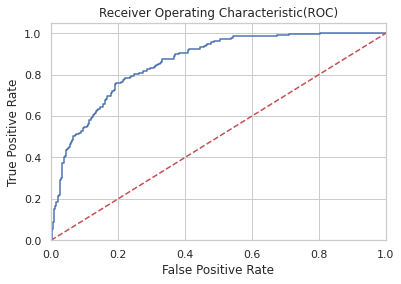

In [126]:
# Roc Curve
logistic_regression = LogisticRegression(random_state=0,solver="liblinear").fit(X,y)

logistic_regression_roc = roc_auc_score(y,logistic_regression.predict(X))

fp,tp,trshld = roc_curve(y,logistic_regression.predict_proba(X)[:,1])
plt.figure()
plt.plot(fp,tp,label="Area Under Curve(AUC)" %logistic_regression_roc)
plt.plot([0,1],[0,1],"r--")
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic(ROC)")
plt.show()

In [127]:
# We will tune our model with GridSearch.
lg_params ={"penalty":["l1", "l2", "elasticnet", "none"],
            "C": list(range(10)),
            "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}

In [128]:
logreg = LogisticRegression()
logistic_regression_cv = GridSearchCV(logreg,lg_params,cv=8)

In [ ]:
start_time = time.time()

logistic_regression_cv.fit(X_train,y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time for logistic_regression_cv cross validation: "
      f"{elapsed_time:.3f} seconds")

In [130]:
#best score
logistic_regression_cv.best_score_

0.7833333333333334

In [131]:
#best parameters
logistic_regression_cv.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

In [ ]:
logreg_tuned = LogisticRegression(C= 1, penalty= "l2", solver= "lbfgs").fit(X_train,y_train)
logreg_tuned

In [133]:
y_pred = logreg_tuned.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
cm

array([[96, 12],
       [27, 33]])

In [134]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       108
         1.0       0.73      0.55      0.63        60

    accuracy                           0.77       168
   macro avg       0.76      0.72      0.73       168
weighted avg       0.76      0.77      0.76       168



In [136]:
# Support Vector Machines

X = df.drop("OUTCOME",axis=1)
y= df["OUTCOME"] #We will predict Outcome(diabetes) 

In [137]:
X_train = X.iloc[:600]
X_test = X.iloc[600:]
y_train = y[:600]
y_test = y[600:]

print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("y_train Shape: ",y_train.shape)
print("y_test Shape: ",y_test.shape)

X_train Shape:  (600, 17)
X_test Shape:  (168, 17)
y_train Shape:  (600,)
y_test Shape:  (168,)


In [138]:
support_vector_classifier = SVC(kernel="linear").fit(X_train,y_train)

In [139]:
# Default C
support_vector_classifier.C

1.0

In [140]:
y_pred = support_vector_classifier.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.89      0.83       108
         1.0       0.73      0.55      0.63        60

    accuracy                           0.77       168
   macro avg       0.76      0.72      0.73       168
weighted avg       0.76      0.77      0.76       168



In [141]:
accuracies= cross_val_score(estimator=support_vector_classifier,
                            X=X_train,y=y_train,
                            cv=10)
print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standart Deviation of Accuracies: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 79.00 %
Standart Deviation of Accuracies: 3.74 %


In [142]:
svm_params ={"C":np.arange(1,5)}
svm = SVC(kernel="linear")
svm_cv = GridSearchCV(svm,svm_params,cv=5,n_jobs =-1)

In [143]:
svm_cv.fit(X_train,y_train)
svm_cv.best_score_

0.7699999999999999

In [144]:
#best parameters
svm_cv.best_params_

{'C': 1}

In [145]:
# SVM Radial Basis Kernel

X = df.drop("OUTCOME",axis=1)
y= df["OUTCOME"] #We will predict Outcome(diabetes) 

X_train = X.iloc[:600]
X_test = X.iloc[600:]
y_train = y[:600]
y_test = y[600:]

print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("y_train Shape: ",y_train.shape)
print("y_test Shape: ",y_test.shape)

support_vector_classifier = SVC(kernel="rbf").fit(X_train,y_train)

y_pred = support_vector_classifier.predict(X_test)

cm = confusion_matrix(y_test,y_pred)

print(classification_report(y_test,y_pred))

X_train Shape:  (600, 17)
X_test Shape:  (168, 17)
y_train Shape:  (600,)
y_test Shape:  (168,)
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79       108
         1.0       0.64      0.47      0.54        60

    accuracy                           0.71       168
   macro avg       0.69      0.66      0.67       168
weighted avg       0.70      0.71      0.70       168



In [146]:
accuracies= cross_val_score(estimator=support_vector_classifier,
                            X=X_train,y=y_train,
                            cv=10)
print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standart Deviation of Accuracies: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 74.83 %
Standart Deviation of Accuracies: 3.20 %


In [147]:
svc_params ={"C":[0.0001,0.001,0.01,0.1,0.5,1,3,5,7,10,40,80,100],
             "gamma":[0.0001,0.001,0.01,0.1,0.5,1,5,10,30,50,100]}

svc = SVC(kernel="rbf")
svc_cv = GridSearchCV(svc,svc_params,cv=5,n_jobs=-1,verbose=2)

In [148]:
svc_cv.fit(X_train,y_train)

Fitting 5 folds for each of 143 candidates, totalling 715 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3, 5, 7, 10,
                               40, 80, 100],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 30,
                                   50, 100]},
             verbose=2)

In [149]:
#best score
svc_cv.best_score_

0.7766666666666666

In [150]:
#best parameters
svc_cv.best_params_

{'C': 7, 'gamma': 0.001}

In [151]:
svc_tuned = SVC(kernel="rbf", C=7, gamma=0.001).fit(X_train,y_train)

In [152]:
y_pred = svc_tuned.predict(X_test)

In [153]:
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81       108
         1.0       0.68      0.53      0.60        60

    accuracy                           0.74       168
   macro avg       0.72      0.70      0.71       168
weighted avg       0.74      0.74      0.74       168



In [154]:
# Decision Tree Classification

X = df.drop("OUTCOME",axis=1)
y= df["OUTCOME"] #We will predict Outcome(diabetes) 

X_train = X.iloc[:600]
X_test = X.iloc[600:]
y_train = y[:600]
y_test = y[600:]

print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print("y_train Shape: ",y_train.shape)
print("y_test Shape: ",y_test.shape)

decision_tree = DecisionTreeClassifier().fit(X_train,y_train)
decision_tree.get_params()

X_train Shape:  (600, 17)
X_test Shape:  (168, 17)
y_train Shape:  (600,)
y_test Shape:  (168,)


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [155]:
print(skompile(decision_tree.predict).to("python/code"))

((((((((0 if x[3] <= 0.285714291036129 else 1) if x[2] <= -1.3125 else 0 if
    x[10] <= -0.31633803248405457 else (1 if x[8] <= 0.22746486077085137 else
    0) if x[2] <= -0.4375 else 0) if x[5] <= 0.5549450814723969 else 1 if x
    [5] <= 0.5714285969734192 else 0 if x[3] <= 1.714285671710968 else 1 if
    x[5] <= 0.8186813294887543 else 0) if x[6] <= 2.1137255430221558 else 0 if
    x[2] <= -0.25 else 1) if x[0] <= 1.300000011920929 else 1 if x[8] <= 
    -0.6812886893749237 else 0) if x[8] <= 2.014414370059967 else 1) if x[1
    ] <= -0.43209876120090485 else ((0 if x[6] <= 0.7830065488815308 else (
    1 if x[6] <= 1.399999976158142 else 0) if x[1] <= -0.23456790298223495 else
    0) if x[9] <= 1.1068382859230042 else 1) if x[3] <= -0.0714285746216774
     else (0 if x[5] <= -0.6483516693115234 else (((0 if x[7] <= 
    0.3772377222776413 else 1 if x[7] <= 0.4532470703125 else 0) if x[8] <=
    1.734754502773285 else 1) if x[14] <= 0.5 else 1) if x[6] <= 
    -0.3516339957714081 e

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


[Text(0.47493990384615387, 0.9666666666666667, 'X[10] <= -0.035\ngini = 0.453\nsamples = 100.0%\nvalue = [0.653, 0.347]'),
 Text(0.19391025641025642, 0.9, 'X[1] <= -0.432\ngini = 0.239\nsamples = 49.2%\nvalue = [0.861, 0.139]'),
 Text(0.1346153846153846, 0.8333333333333334, 'X[8] <= 2.014\ngini = 0.098\nsamples = 25.7%\nvalue = [0.948, 0.052]'),
 Text(0.12435897435897436, 0.7666666666666667, 'X[0] <= 1.3\ngini = 0.087\nsamples = 25.5%\nvalue = [0.954, 0.046]'),
 Text(0.09487179487179487, 0.7, 'X[6] <= 2.114\ngini = 0.066\nsamples = 24.5%\nvalue = [0.966, 0.034]'),
 Text(0.06666666666666667, 0.6333333333333333, 'X[5] <= 0.555\ngini = 0.054\nsamples = 23.8%\nvalue = [0.972, 0.028]'),
 Text(0.041025641025641026, 0.5666666666666667, 'X[2] <= -1.312\ngini = 0.031\nsamples = 21.0%\nvalue = [0.984, 0.016]'),
 Text(0.020512820512820513, 0.5, 'X[3] <= 0.286\ngini = 0.245\nsamples = 1.2%\nvalue = [0.857, 0.143]'),
 Text(0.010256410256410256, 0.43333333333333335, 'gini = 0.0\nsamples = 1.0%\nvalu

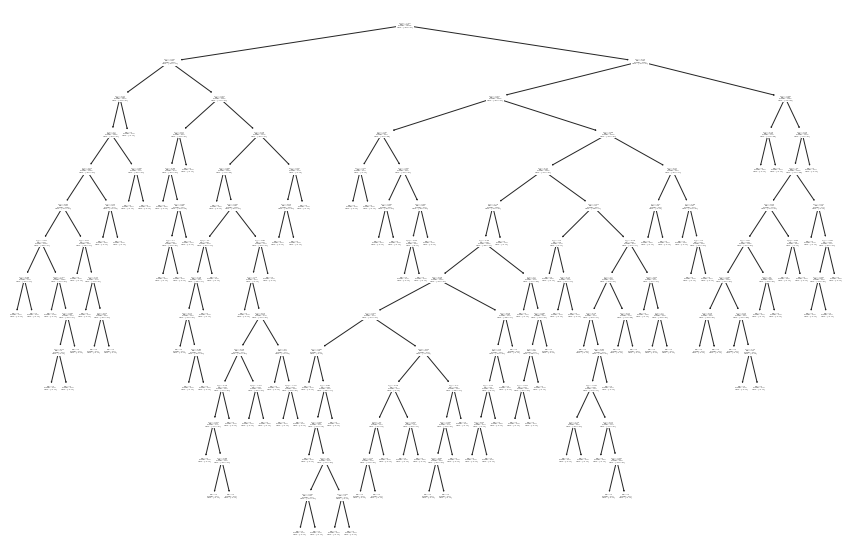

In [156]:
plt.figure(figsize=(15,10))
plot_tree(decision_tree,proportion=True)

In [157]:
y_pred = decision_tree.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79       108
         1.0       0.62      0.70      0.66        60

    accuracy                           0.74       168
   macro avg       0.72      0.73      0.72       168
weighted avg       0.75      0.74      0.74       168



In [158]:
accuracies= cross_val_score(estimator=decision_tree,
                            X=X_train,y=y_train,
                            cv=10)
print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standart Deviation of Accuracies: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 69.50 %
Standart Deviation of Accuracies: 6.75 %


In [159]:
decision_tree_params ={"criterion":["gini","entropy"],
                       "max_depth":[1,2,3,4,5,6,7,8,9,10],
                       "min_samples_split":list(range(1,10))}

In [160]:
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_cv = GridSearchCV(decision_tree_classifier,decision_tree_params,cv=9,n_jobs=-1,verbose=2)

In [ ]:
decision_tree_cv.fit(X_train,y_train)

In [162]:
#best score
decision_tree_cv.best_score_

0.7567716970702045

In [163]:
#best parameters
decision_tree_cv.best_params_

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 4}

In [164]:
decision_tree_tuned = DecisionTreeClassifier(criterion="entropy",max_depth=6,min_samples_split=4).fit(X_train,y_train)

In [165]:
y_pred = decision_tree_tuned.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83       108
         1.0       0.70      0.63      0.67        60

    accuracy                           0.77       168
   macro avg       0.76      0.74      0.75       168
weighted avg       0.77      0.77      0.77       168



In [30]:
# Random Forests Classification

X = df.drop("OUTCOME",axis=1)
y= df["OUTCOME"] #We will predict Outcome(diabetes) 

X_train = X.iloc[:600]
X_test = X.iloc[600:]
y_train = y[:600]
y_test = y[600:]

random_forest = RandomForestClassifier().fit(X_train,y_train)

In [31]:
random_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [32]:
feature_importances =pd.DataFrame({"Features":X_train.columns,
              "Feature Imporances": random_forest.feature_importances_}).sort_values(by="Feature Imporances")

feature_importances.head()

,Features,Feature Imporances
16,NEW_BP_CAT_HIGH PRESSURE,0.003652
14,NEW_BP_CAT_NORMAL PRESSURE,0.006344
15,NEW_BP_CAT_HIGH-NORMAL PRESSURE,0.006729
11,NEW_BMI_CAT_NORMALY WEIGHT,0.008012
12,NEW_BMI_CAT_OVER WEIGHT,0.008647


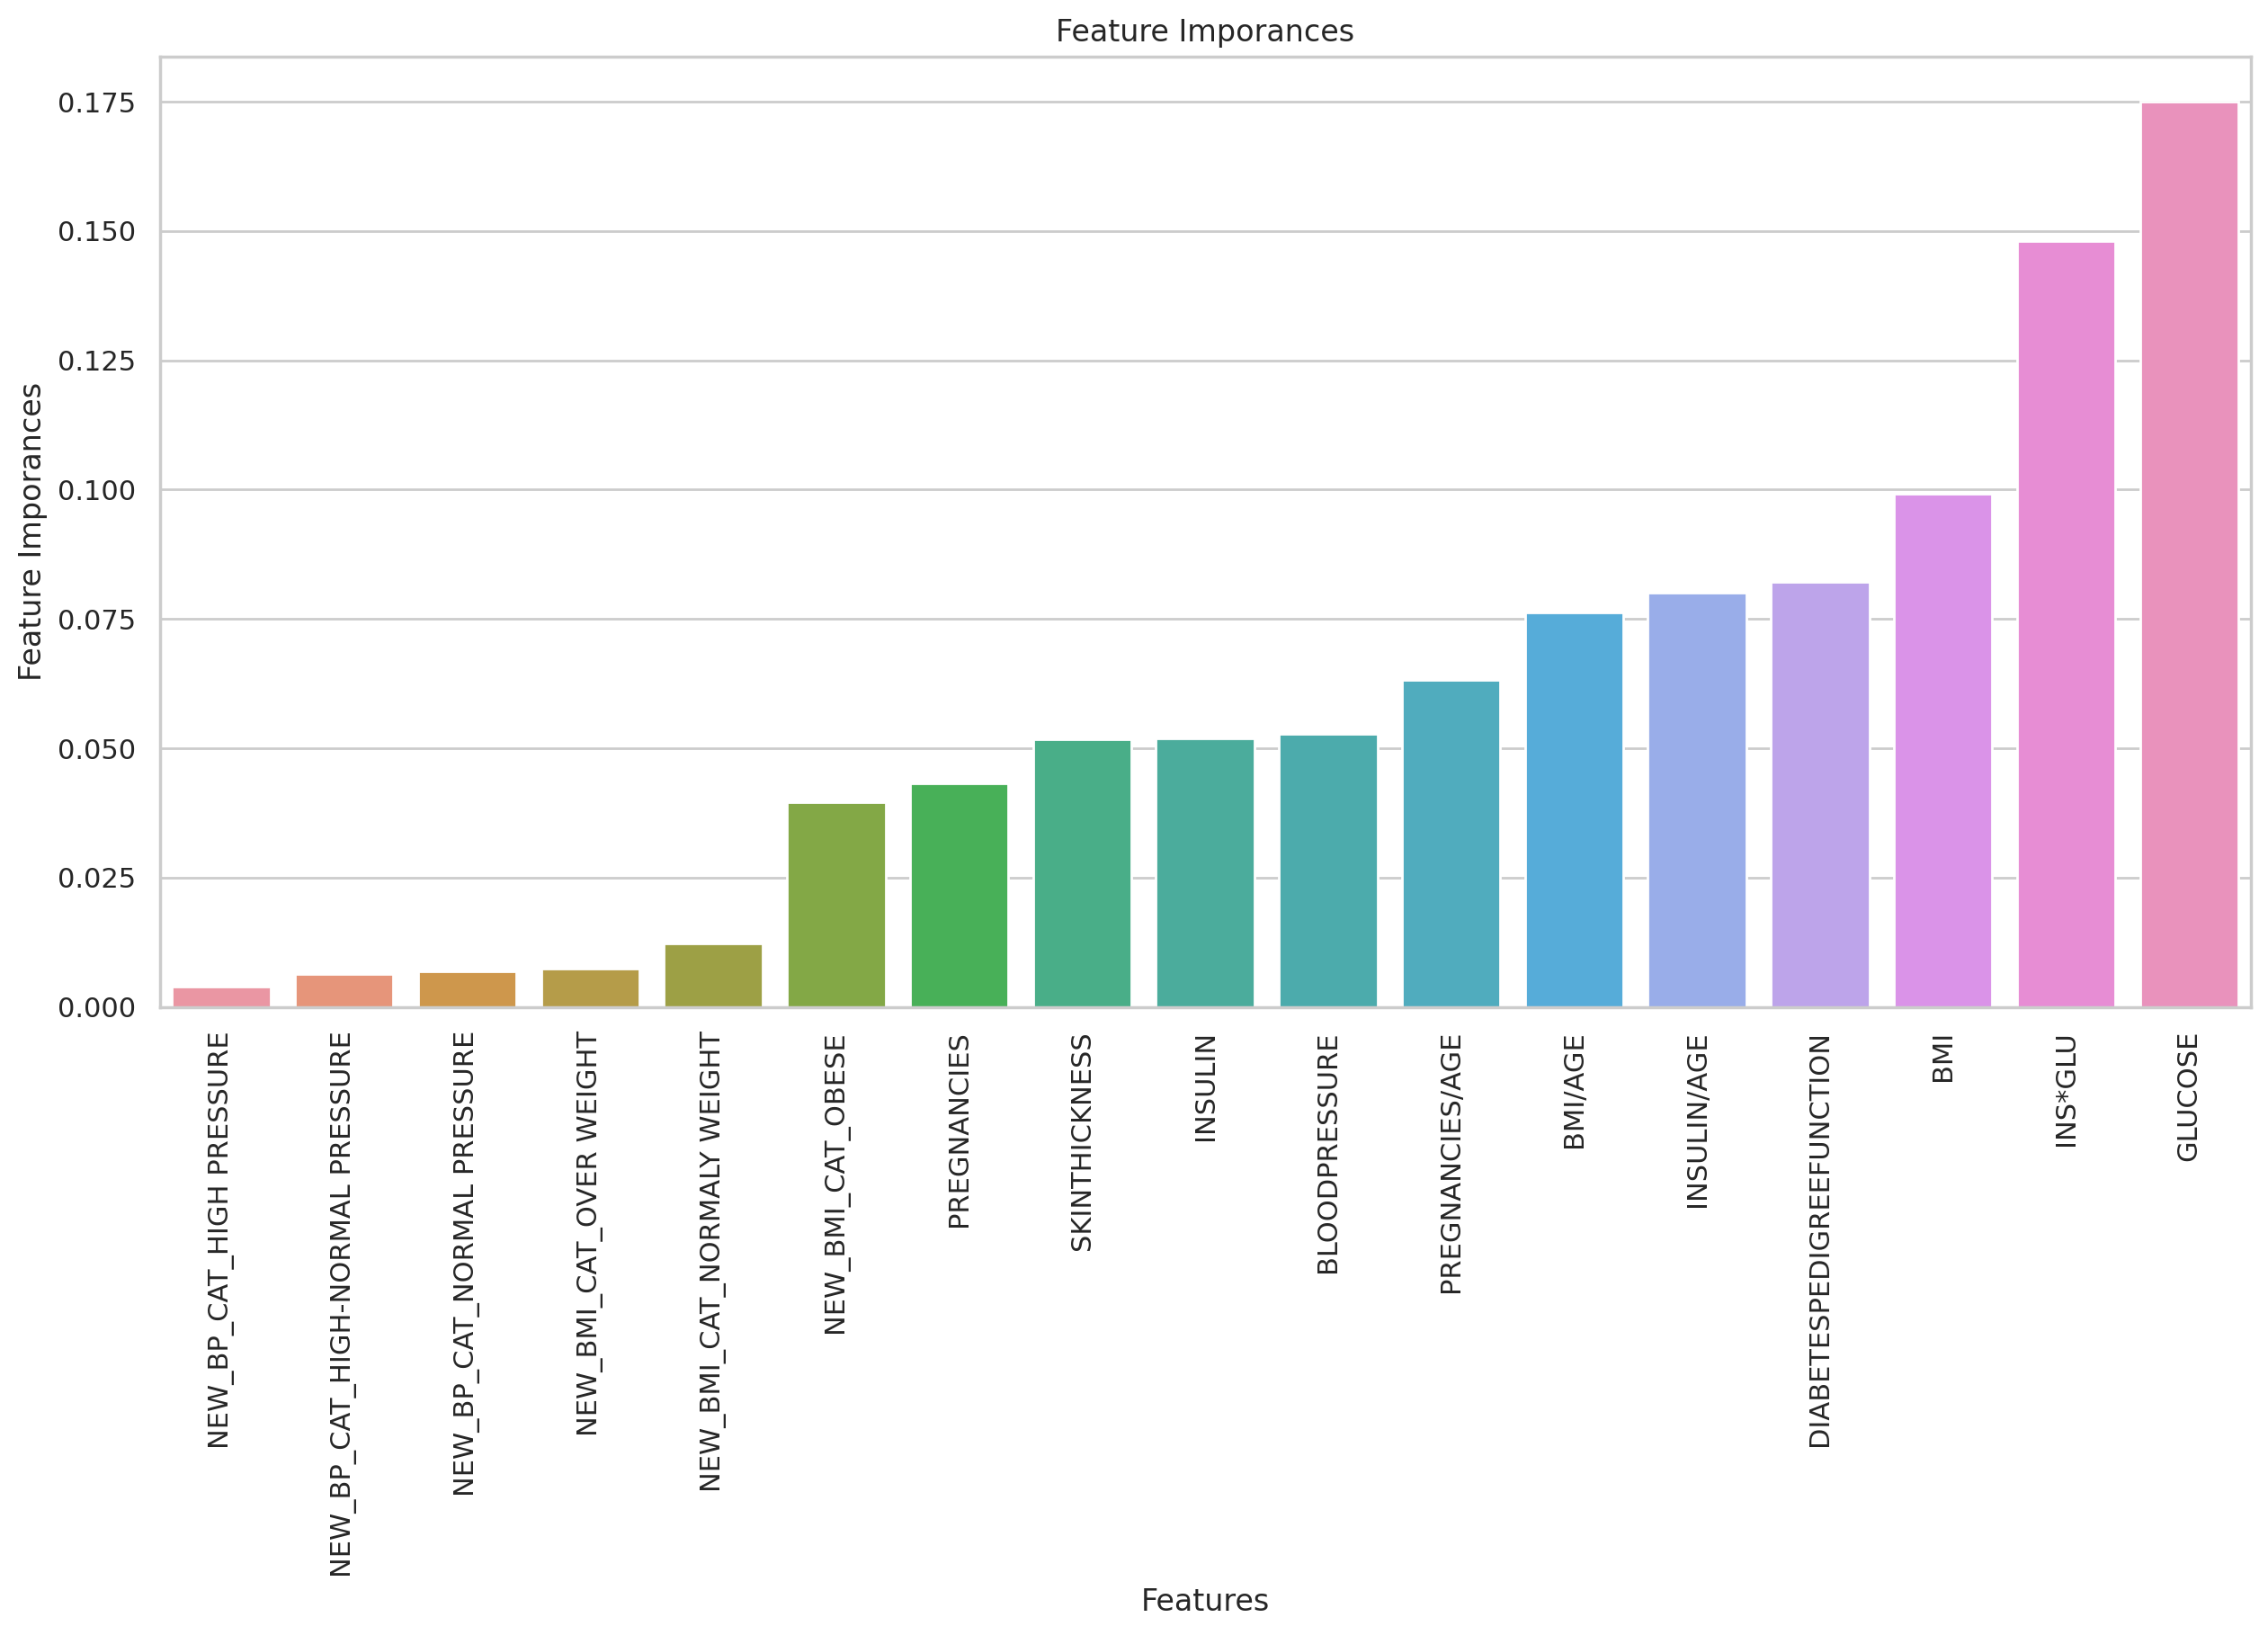

In [169]:
plt.figure(figsize=(15,7),dpi=200)
sns.barplot(data=feature_importances,x="Features",y="Feature Imporances")
plt.title("Feature Imporances")
plt.xticks(rotation=90)
plt.show()

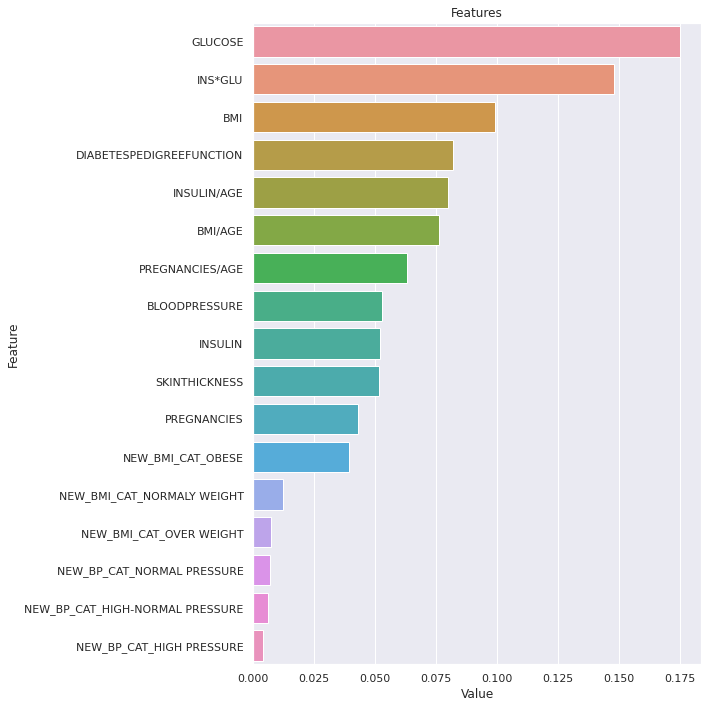

In [170]:

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(random_forest, X_train)

In [33]:
y_pred = random_forest.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.83      0.81       108
         1.0       0.66      0.58      0.62        60

    accuracy                           0.74       168
   macro avg       0.72      0.71      0.71       168
weighted avg       0.74      0.74      0.74       168



In [34]:
accuracies= cross_val_score(estimator=random_forest,
                            X=X_train,y=y_train,
                            cv=10)
print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standart Deviation of Accuracies: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 78.17 %
Standart Deviation of Accuracies: 5.98 %


In [38]:
random_forests_params = {"max_depth": list(range(1,5)),
                         "max_features":[2,5],
                         "n_estimators":[300,500],
                         "criterion":["gini","entropy"]}

In [39]:
random_forest_classifier = RandomForestClassifier()
random_forest_cv = GridSearchCV(random_forest_classifier,random_forests_params,cv=9,n_jobs=-1,verbose=2)

In [40]:
random_forest_cv.fit(X_train,y_train)

Fitting 9 folds for each of 32 candidates, totalling 288 fits


GridSearchCV(cv=9, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4], 'max_features': [2, 5],
                         'n_estimators': [300, 500]},
             verbose=2)

In [41]:
#best parameters
random_forest_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 5,
 'n_estimators': 500}

In [42]:
random_forest_tuned = RandomForestClassifier(criterion="entropy",max_depth=4,max_features=5,
                                             n_estimators=500).fit(X_train,y_train)

In [43]:
y_pred = random_forest_tuned.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80       108
         1.0       0.65      0.58      0.61        60

    accuracy                           0.74       168
   macro avg       0.71      0.70      0.71       168
weighted avg       0.73      0.74      0.73       168



In [44]:
Importances = pd.DataFrame({"Importance":random_forest_tuned.feature_importances_*100},index=X_train.columns)
Importances.head()

,Importance
PREGNANCIES,2.992675
GLUCOSE,23.801095
BLOODPRESSURE,2.082817
SKINTHICKNESS,2.729077
INSULIN,5.836529


Text(0.5, 1.0, 'Feature Importances')

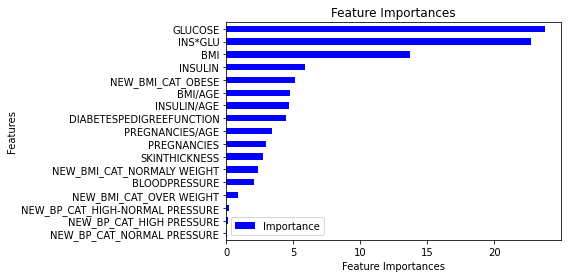

In [45]:
Importances.sort_values(by="Importance",axis=0,ascending=True).plot(kind="barh",color="b")
plt.xlabel("Feature Importances")
plt.ylabel("Features")
plt.title("Feature Importances")

In [46]:
# XGBoost (Extreme Gradient Boosting) Classification
X = df.drop("OUTCOME",axis=1)
y= df["OUTCOME"] #We will predict Outcome(diabetes) 

X_train = X.iloc[:600]
X_test = X.iloc[600:]
y_train = y[:600]
y_test = y[600:]

xgb_classifier = XGBClassifier().fit(X_train,y_train)

In [47]:
y_pred = xgb_classifier.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       108
         1.0       0.74      0.67      0.70        60

    accuracy                           0.80       168
   macro avg       0.78      0.77      0.77       168
weighted avg       0.79      0.80      0.80       168



In [48]:
accuracies= cross_val_score(estimator=xgb_classifier,
                            X=X_train,y=y_train,
                            cv=10)
print("Average Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standart Deviation of Accuracies: {:.2f} %".format(accuracies.std()*100))

Average Accuracy: 76.50 %
Standart Deviation of Accuracies: 5.89 %


In [49]:
xgboost_params ={"learning_rate":[0.1,0.01,0.02,0.05],
                 "subsample":[0.6,0.8,1.0],
                 "max_depth":[1,2,3,4,5],
                 "n_estimators":[100,500]}

In [50]:
xgboost_classifier = XGBClassifier()
xgboost_cv = GridSearchCV(xgboost_classifier,xgboost_params,cv=9,n_jobs=-1,verbose=2)

In [51]:
xgboost_cv.fit(X_train,y_train)

Fitting 9 folds for each of 120 candidates, totalling 1080 fits


GridSearchCV(cv=9, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.02, 0.05],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [100, 500],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [52]:
#best parameters
xgboost_cv.best_params_

{'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1.0}

In [53]:
xgboost_tuned = XGBClassifier(learning_rate=0.02,max_depth=4,
                              subsample=1,n_estimators=100).fit(X_train,y_train)

In [54]:
y_pred = xgboost_tuned.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81       108
         1.0       0.66      0.63      0.64        60

    accuracy                           0.75       168
   macro avg       0.73      0.72      0.73       168
weighted avg       0.75      0.75      0.75       168



In [55]:
result = {'Model': ['Logistic Regression Classification', 'K - Nearest Neighbors(KNN)', 'Support Vector Classification(SVC) with Linear Kernel', 
                  'Support Vector Classification with Radial Basis Kernel','Decision Tree Classification',
                  'Random Forests Classification','XGBoost Classification'], 
        'Accuracy': [0.77,0.71,0.77,0.74,0.77,0.74,0.75],
        'F1 Score': [0.63,0.54,0.63,0.6,0.67,0.61,0.64]}  

result = pd.DataFrame(result)  

In [56]:
result

,Model,Accuracy,F1 Score
0,Logistic Regression Classification,0.77,0.63
1,K - Nearest Neighbors(KNN),0.71,0.54
2,Support Vector Classification(SVC) with Linear...,0.77,0.63
3,Support Vector Classification with Radial Basi...,0.74,0.60
4,Decision Tree Classification,0.77,0.67
5,Random Forests Classification,0.74,0.61
6,XGBoost Classification,0.75,0.64
